In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
 ## imports 
import pandas as pd
import numpy as np
from itertools import product
from sklearn.utils import shuffle
np.random.seed(20)



In [6]:
sales = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitive data science/Final Project/sales_train.csv.gz')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


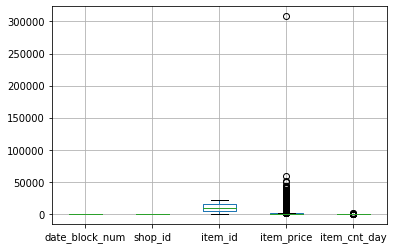

In [7]:
sales.boxplot()  # make a boxplot for all variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01a02a5ba8>]],
      dtype=object)

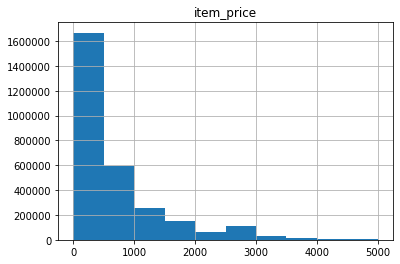

In [10]:
# seeing outliers let's set a threshold and see histogram
sales[sales['item_price'] <= 5000][['item_price']].hist()

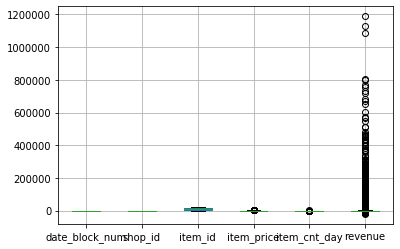

In [12]:
sales = sales[sales['item_price'] <= 5000]
sales['revenue'] = sales['item_price'] * sales['item_cnt_day']
sales.boxplot()

In [13]:
# Process as in assignment to retrieve target
import gc
from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

sales = downcast_dtypes(sales)

#perform aggregation
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}, 'item_price': {'monthly_price_avg': 'mean'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data.head()


/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,monthly_price_avg
138084,0,19,0,0.0,0.0
140305,0,27,0,0.0,0.0
143761,0,28,0,0.0,0.0
141460,0,29,0,0.0,0.0
137777,0,32,0,6.0,221.0


In [18]:
# make a feature of returned items
all_data['returned_cnt_sum'] = all_data['item_id'].map(sales[sales['item_cnt_day'] < 0][['item_id', 'item_cnt_day']].groupby('item_id').item_cnt_day.sum())
all_data['returned_cnt_sum'].fillna(all_data['returned_cnt_sum'].mean(), inplace=True)
all_data['returned_cnt_sum'] =  all_data['returned_cnt_sum'].apply(lambda x: abs(x))
del sales  # to save memory
all_data.head()

,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum
138084,0,19,0,0.0,0.0,2.38532
140305,0,27,0,0.0,0.0,2.38532
143761,0,28,0,0.0,0.0,1.00000
141460,0,29,0,0.0,0.0,1.00000
137777,0,32,0,6.0,221.0,2.00000


In [19]:
## Now add make an id based on shop_id, item_id and date_block_num, and another variable concatenating both (for predictions in the future)
all_data['ID'] = all_data['shop_id'].astype(str) + all_data['item_id'].astype(str) + all_data['date_block_num'].astype(str)
print('All data shape', all_data.shape)
all_data.drop_duplicates(subset=['ID'], inplace=True)
print('Shape after dropping (if existent) duplicates', all_data.shape)
all_data['shop_item_id'] = all_data['shop_id'].astype(str) + all_data['item_id'].astype(str)
all_data.index = all_data['ID']
all_data.head()

All data shape (10796513, 7)
Shape after dropping (if existent) duplicates (10335332, 7)


,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id
ID,,,,,,,,
0190,0,19,0,0.0,0.0,2.38532,0190,019
0270,0,27,0,0.0,0.0,2.38532,0270,027
0280,0,28,0,0.0,0.0,1.00000,0280,028
0290,0,29,0,0.0,0.0,1.00000,0290,029
0320,0,32,0,6.0,221.0,2.00000,0320,032


In [20]:
# now open test set, to see which combinations are there and which are not.
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/test.csv.gz', index_col='ID')
test['shop_item_id'] = test['shop_id'].astype(str) + test['item_id'].astype(str)
test.head()

,shop_id,item_id,shop_item_id
ID,,,
0,5,5037,55037
1,5,5320,55320
2,5,5233,55233
3,5,5232,55232
4,5,5268,55268


In [21]:
# now check shapes
print(all_data.shape)
print(test.shape)

(10335332, 8)
(214200, 3)


In [22]:
# now drop all shop_item_id that is not in test
all_data = all_data[all_data['shop_item_id'].isin(test['shop_item_id'])]
print('New shape', all_data.shape)
all_data.to_csv('/content/drive/My Drive/Colab Notebooks/Competitive data science/Final Project/all_data.csv.gz', index=False)
del all_data  # to avoid crashing session
del test

New shape (2760686, 8)


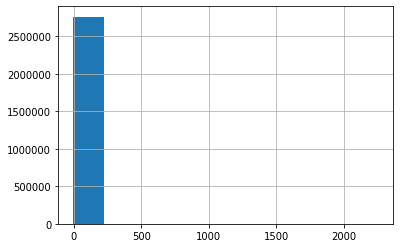

In [23]:
# we see quite a significant decrease. Let us plot the target distribution
all_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitive data science/Final Project/all_data.csv.gz')
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
all_data['target'].hist()

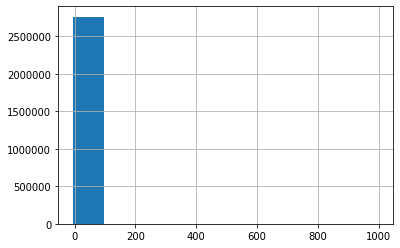

In [24]:
all_data[all_data['target'] < 1000]['target'].hist()

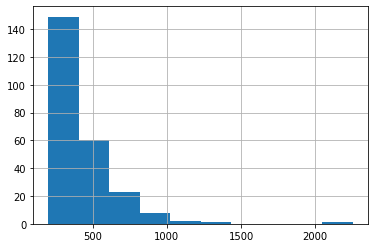

In [27]:
all_data[all_data['target'] > 200]['target'].hist()


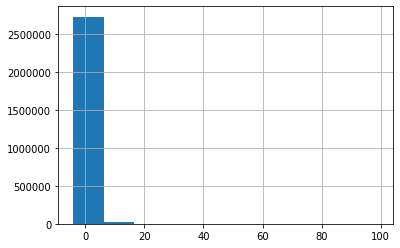

In [28]:
all_data[all_data['target'] < 100]['target'].hist()